Importamos librerías que usaremos

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
load_dotenv()


user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db = os.getenv('DB_NAME')

url_conexion = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}"


engine = create_engine(url_conexion)

In [3]:
query = """
SELECT * FROM customer_rfm
"""

crfm = pd.read_sql(query, engine)

In [28]:
crfm.shape

(94989, 5)

## Análisis de Recency

<Axes: xlabel='recency', ylabel='Count'>

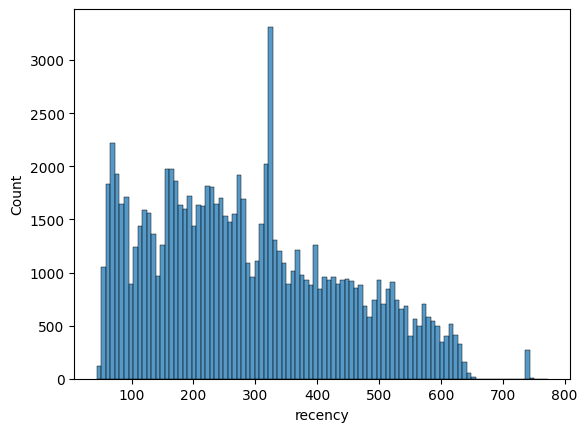

In [30]:
sns.histplot(data=crfm, x = 'recency',bins = 100)

In [5]:
print([x for x in range(10,0,-1)])

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [16]:
n = 5

In [17]:
crfm['R_score'] = pd.qcut(crfm['recency'],n,labels=[x for x in range(n,0,-1)])

In [24]:
resumen_cortes = crfm.groupby('R_score')['recency'].agg(['min', 'max', 'count', 'mean','median'])
resumen_cortes.sort_index(ascending=False)

,min,max,count,mean,median
R_score,,,,,
1,433,773,18968,523.385966,516.0
2,318,432,18929,365.841407,363.0
3,227,317,19007,269.615931,268.0
4,143,226,18952,185.071655,184.0
5,44,142,19133,94.595725,91.0


C:\Users\Domakei\AppData\Local\Temp\ipykernel_21156\2384348273.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='R_score', y='recency', data=crfm, palette='viridis')


<Axes: xlabel='R_score', ylabel='recency'>

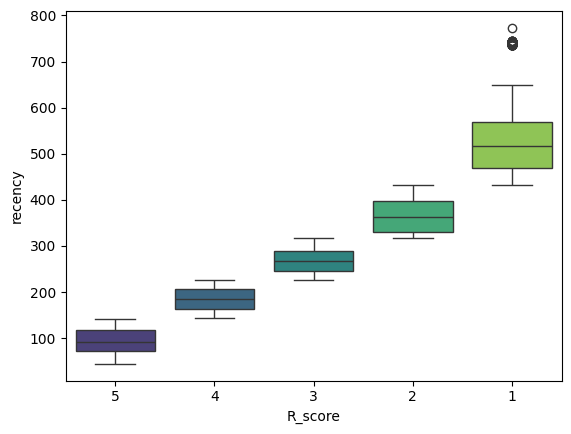

In [19]:
sns.boxplot(x='R_score', y='recency', data=crfm, palette='viridis')

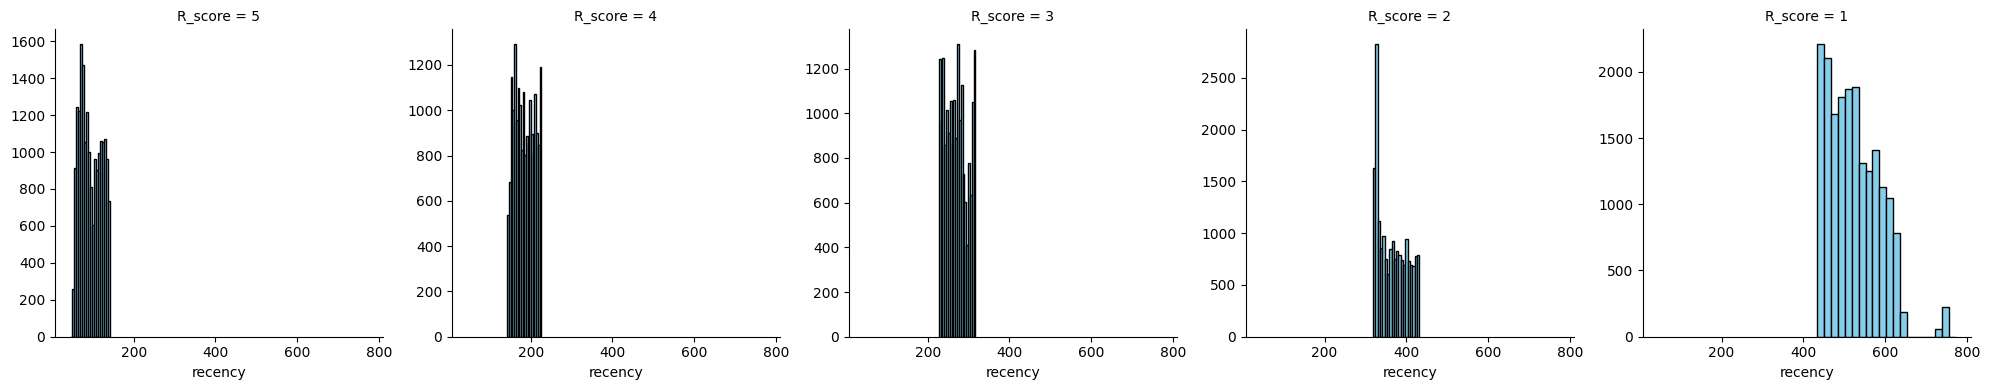

In [20]:
g = sns.FacetGrid(crfm, col="R_score", sharey=False, height=4)
g.map(plt.hist, "recency", bins=20, color='skyblue', edgecolor='black')
plt.show()

## Frequency

<Axes: xlabel='frequency', ylabel='count'>

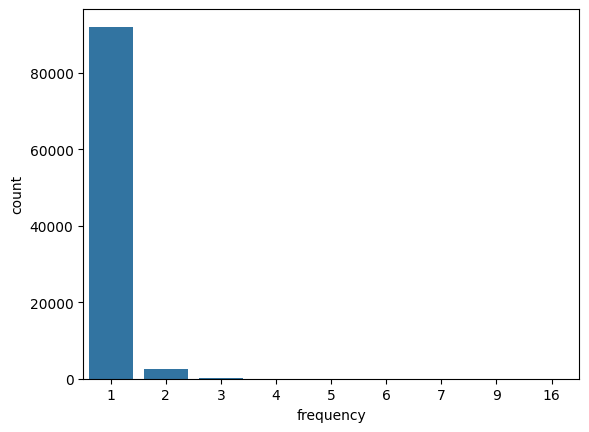

In [21]:
sns.countplot(data = crfm, x = 'frequency')